<a href="https://colab.research.google.com/github/snotani/FridgeBuddy/blob/master/AE_ECG_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset and pre-processing

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# ECG dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [19]:
# Labels are in the last column
labels = raw_data[:, -1]

# rows from 0 to 140
data = raw_data[:, 0:-1]  

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=21)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(3998, 140)
(1000, 140)


In [20]:
# Claim models
import keras
import matplotlib.pyplot as plt

#input size
input_size = 140
# The input size/image
input_img = keras.Input(shape=(input_size,))
# The size of latent space
encoding_dim = 64
## Add a simple encode layer
# encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)
# You can add encode layer with a L1 activity regularizer
encoded = keras.layers.Dense(encoding_dim, activation='relu', 
                activity_regularizer=keras.regularizers.l1(10e-5))(input_img)
# Add decode layer
decoded = keras.layers.Dense(input_size, activation='sigmoid')(encoded)

# Claim autoencoder model
model_autoencoder = keras.Model(input_img, decoded)

# Claim a separate encoder model
model_encoder = keras.Model(input_img, encoded)

# Claim a separate decoder model
decoder_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_autoencoder.layers[-1]
# Create the decoder model
model_decoder = keras.Model(decoder_input, decoder_layer(decoder_input))

# Training

Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.6903 - val_loss: 0.6790
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6730 - val_loss: 0.6501
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6395 - val_loss: 0.6018
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.5862 - val_loss: 0.5346
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.5152 - val_loss: 0.4546
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.4335 - val_loss: 0.3705
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3500 - val_loss: 0.2910
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2729 - val_loss: 0.2229
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2078 - val_loss: 0.1691
Epoch 10/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1580 - val_loss: 0.1290
Epoch 1

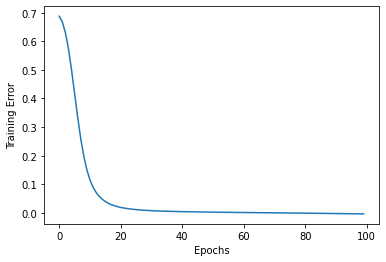

In [21]:
# Training
# Claim compile property for training
model_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model
hist=model_autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

# Supervised Classification with AE

In [26]:
model = keras.Sequential()
model.add(model_encoder.layers[0])
model.add(model_encoder.layers[1])
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)

# Train the model, iterating on the data in batches of 32 samples
model.fit(x_train, one_hot_labels, epochs=10, batch_size=32)

Epoch 1/10
125/125 [==============================] - 1s 1ms/step - loss: 0.7467 - accuracy: 0.6267
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.3262 - accuracy: 0.9585
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.9714
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9719
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0914 - accuracy: 0.9721
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0814 - accuracy: 0.9721
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0808 - accuracy: 0.9690
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0728 - accuracy: 0.9758
Epoch 9/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0741 - accuracy: 0.9747
Epoch 10/10
125/125 [==============================] - 0s 1ms/step - loss: 0.0748 - accuracy: 0.9769

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# Overall F1 score
y_pred=np.argmax(model.predict(x_test), axis=1)
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))

0.9796876777328198
0.980187390201054
0.9792207792207792
